In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/onlinefraud.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and null values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (287568, 11)

First 5 rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  

Data types and null values:
<class 'pandas.core.frame.DataFra

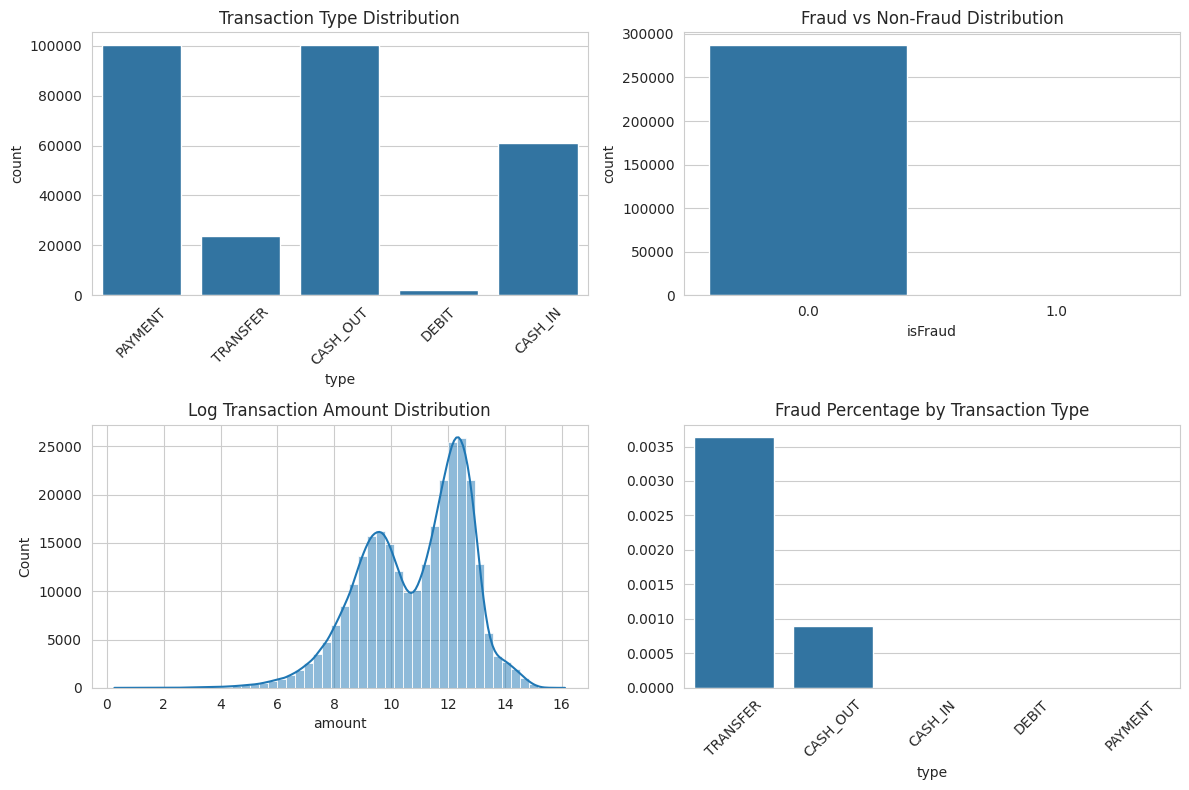

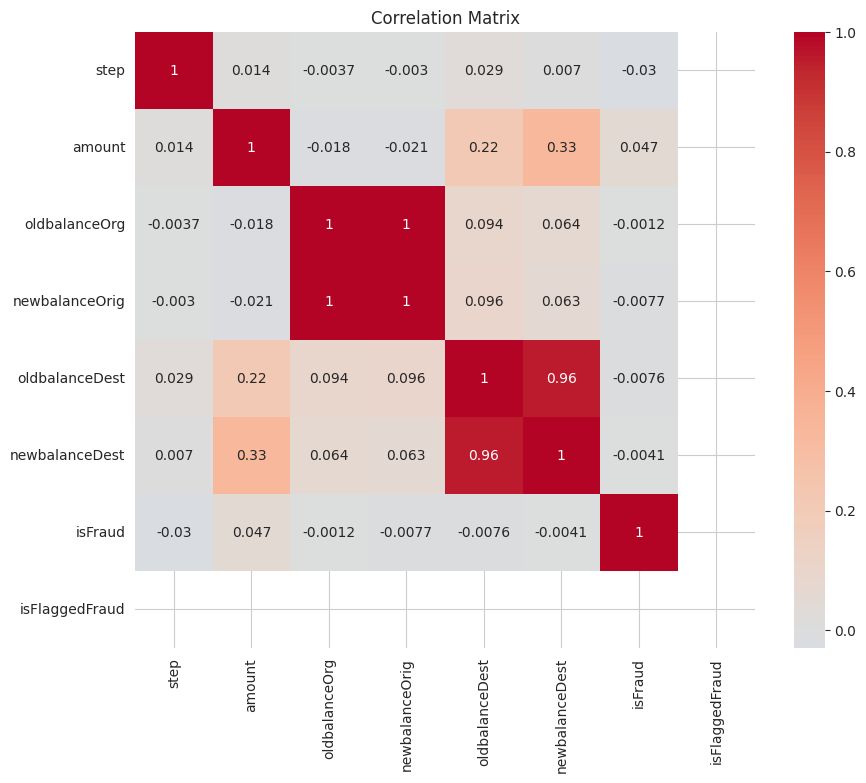

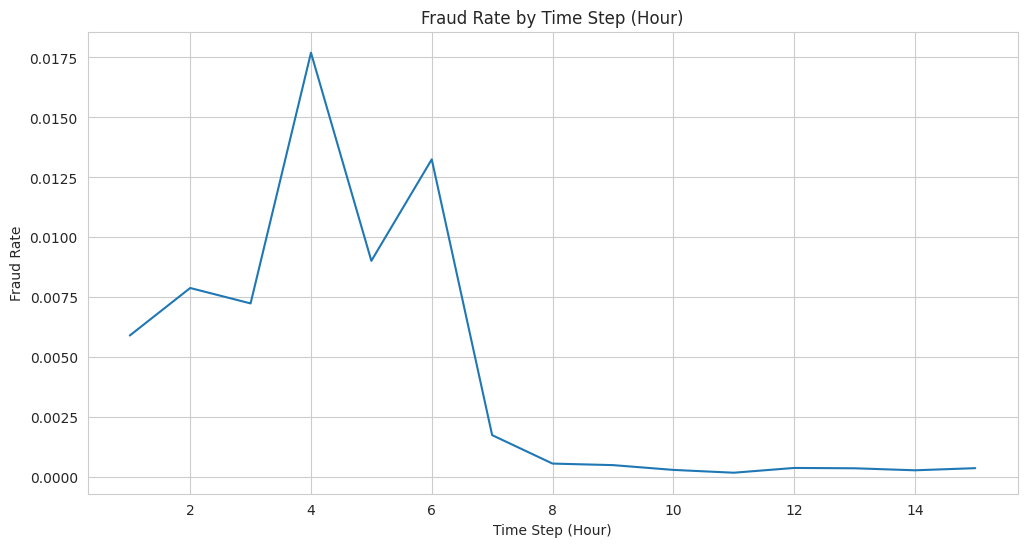

In [2]:
# Set style for plots
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))

# 1. Distribution of transaction types
plt.subplot(2, 2, 1)
sns.countplot(x='type', data=df)
plt.title('Transaction Type Distribution')
plt.xticks(rotation=45)

# 2. Distribution of fraud vs non-fraud
plt.subplot(2, 2, 2)
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Distribution')

# 3. Transaction amount distribution (log scale)
plt.subplot(2, 2, 3)
sns.histplot(np.log1p(df['amount']), bins=50, kde=True)
plt.title('Log Transaction Amount Distribution')

# 4. Fraud by transaction type
plt.subplot(2, 2, 4)
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title('Fraud Percentage by Transaction Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlation analysis
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Time step analysis
fraud_by_step = df.groupby('step')['isFraud'].mean()
plt.figure(figsize=(12, 6))
fraud_by_step.plot()
plt.title('Fraud Rate by Time Step (Hour)')
plt.xlabel('Time Step (Hour)')
plt.ylabel('Fraud Rate')
plt.show()

In [3]:
# Create a copy of the original dataframe for preprocessing
df_processed = df.copy()

# 1. Encode categorical variables
le = LabelEncoder()
df_processed['type'] = le.fit_transform(df_processed['type'])

# 2. Create new features
# Difference between old and new balance (originator)
df_processed['balance_change_orig'] = df_processed['oldbalanceOrg'] - df_processed['newbalanceOrig']

# Difference between old and new balance (destination)
df_processed['balance_change_dest'] = df_processed['newbalanceDest'] - df_processed['oldbalanceDest']

# Transaction amount as percentage of originator's balance
df_processed['amount_pct_of_balance'] = df_processed['amount'] / (df_processed['oldbalanceOrg'] + 1e-6)  # Add small constant to avoid division by zero

# Flag for zero balance before or after transaction
df_processed['zero_balance_orig'] = ((df_processed['oldbalanceOrg'] == 0) | (df_processed['newbalanceOrig'] == 0)).astype(int)
df_processed['zero_balance_dest'] = ((df_processed['oldbalanceDest'] == 0) | (df_processed['newbalanceDest'] == 0)).astype(int)

# 3. Drop unnecessary columns
df_processed.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

# 4. Handle class imbalance (fraud cases are very rare)
print("\nClass distribution before handling imbalance:")
print(df_processed['isFraud'].value_counts(normalize=True))

# Separate majority and minority classes
df_majority = df_processed[df_processed.isFraud == 0]
df_minority = df_processed[df_processed.isFraud == 1]

# Downsample majority class (for faster training, in production you might want to use SMOTE instead)
df_majority_downsampled = resample(df_majority,
                                 replace=False,
                                 n_samples=len(df_minority)*5,  # 5:1 ratio
                                 random_state=42)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

print("\nClass distribution after handling imbalance:")
print(df_balanced['isFraud'].value_counts(normalize=True))

# Alternatively, you could use SMOTE:
# X = df_processed.drop('isFraud', axis=1)
# y = df_processed['isFraud']
# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X, y)
# df_balanced = pd.concat([X_res, y_res], axis=1)


Class distribution before handling imbalance:
isFraud
0.0    0.999384
1.0    0.000616
Name: proportion, dtype: float64

Class distribution after handling imbalance:
isFraud
0.0    0.833333
1.0    0.166667
Name: proportion, dtype: float64



Selected features:
Index(['step', 'type', 'amount', 'newbalanceOrig', 'oldbalanceDest',
       'balance_change_orig', 'balance_change_dest', 'amount_pct_of_balance',
       'zero_balance_orig', 'zero_balance_dest'],
      dtype='object')

Random Forest Performance:
Accuracy: 0.9812
F1 Score: 0.9333
ROC AUC: 0.9888

Confusion Matrix:
[[271   1]
 [  5  42]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       272
         1.0       0.98      0.89      0.93        47

    accuracy                           0.98       319
   macro avg       0.98      0.94      0.96       319
weighted avg       0.98      0.98      0.98       319


Gradient Boosting Performance:
Accuracy: 0.9592
F1 Score: 0.8660
ROC AUC: 0.9861

Confusion Matrix:
[[264   8]
 [  5  42]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       272
         1.0       0.84      0.89

<Figure size 1200x600 with 0 Axes>

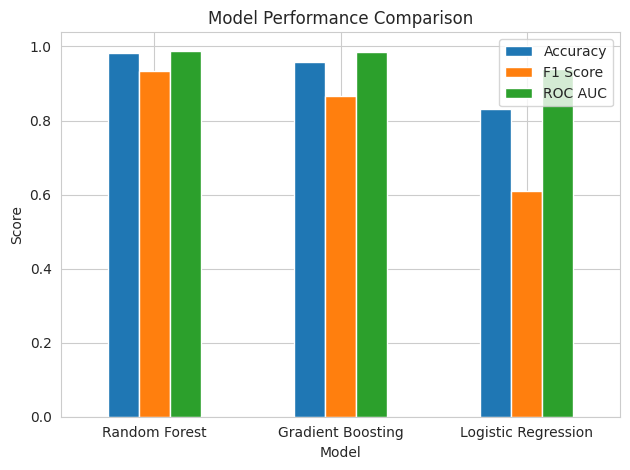

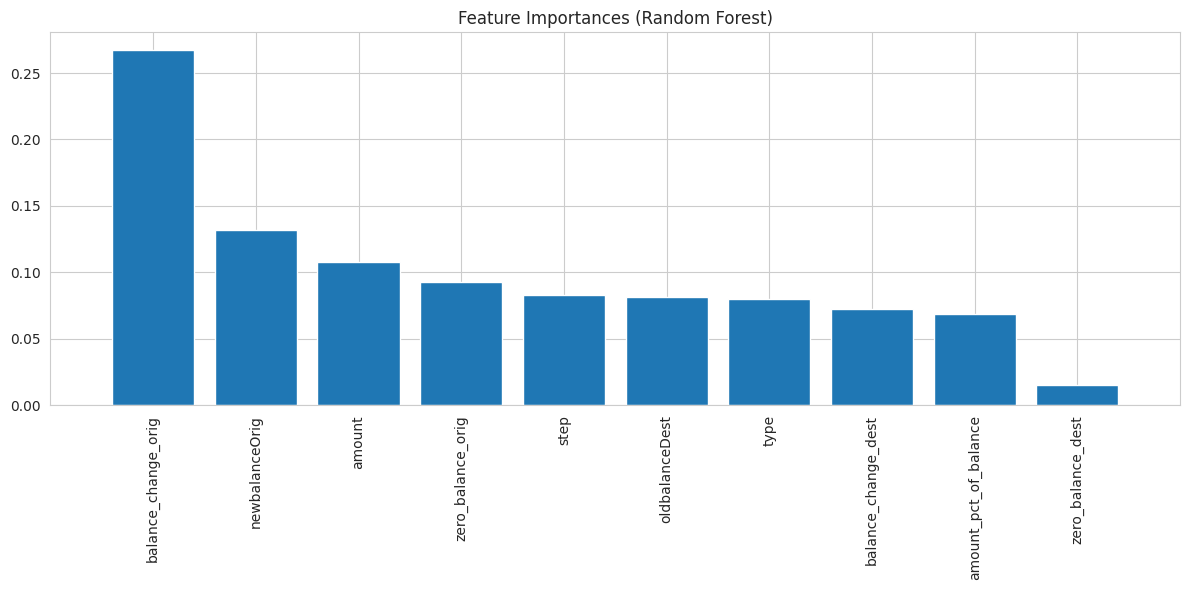

In [4]:
# Split into features and target
X = df_balanced.drop('isFraud', axis=1)
y = df_balanced['isFraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("\nSelected features:")
print(selected_features)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    y_prob = model.predict_proba(X_test_selected)[:, 1]

    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

    # Print results
    print(f"\n{name} Performance:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"F1 Score: {results[name]['f1']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
    print("\nConfusion Matrix:")
    print(results[name]['confusion_matrix'])
    print("\nClassification Report:")
    print(results[name]['classification_report'])

# Plot model comparison
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'F1 Score': [results[name]['f1'] for name in results],
    'ROC AUC': [results[name]['roc_auc'] for name in results]
})

plt.figure(figsize=(12, 6))
metrics_df.set_index('Model').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature importance for Random Forest
best_model = models["Random Forest"]
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train_selected.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_selected.shape[1]), selected_features[indices], rotation=90)
plt.xlim([-1, X_train_selected.shape[1]])
plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import GridSearchCV

# Optimize Random Forest (our best performing model)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=3, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train_selected, y_train)

# Best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)

# Evaluate best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_selected)
y_prob = best_rf.predict_proba(X_test_selected)[:, 1]

print("\nOptimized Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the best model
joblib.dump(best_rf, 'payment_fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(le, 'label_encoder.pkl')

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Optimized Random Forest Performance:
Accuracy: 0.9687
F1 Score: 0.8936
ROC AUC: 0.9890

Confusion Matrix:
[[267   5]
 [  5  42]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       272
         1.0       0.89      0.89      0.89        47

    accuracy                           0.97       319
   macro avg       0.94      0.94      0.94       319
weighted avg       0.97      0.97      0.97       319



['label_encoder.pkl']

In [6]:
# Calculate potential savings from fraud detection
total_amount = df['amount'].sum()
fraud_amount = df[df['isFraud'] == 1]['amount'].sum()
fraud_percentage = (fraud_amount / total_amount) * 100

print(f"\nTotal transaction amount: ${total_amount:,.2f}")
print(f"Total fraud amount: ${fraud_amount:,.2f}")
print(f"Percentage of revenue lost to fraud: {fraud_percentage:.2f}%")

# Estimate savings with our model
# Get predictions on the full dataset (note: we'd need to preprocess it first)
# For demonstration, we'll use the test set results

# Calculate potential savings
fraud_caught = confusion_matrix(y_test, y_pred)[1, 1]  # True positives
fraud_missed = confusion_matrix(y_test, y_pred)[1, 0]  # False negatives
legitimate_blocked = confusion_matrix(y_test, y_pred)[0, 1]  # False positives

# Assuming average fraud amount (in reality, you'd calculate based on actual amounts)
avg_fraud_amount = df[df['isFraud'] == 1]['amount'].mean()
avg_legitimate_amount = df[df['isFraud'] == 0]['amount'].mean()

potential_savings = fraud_caught * avg_fraud_amount
lost_revenue = legitimate_blocked * avg_legitimate_amount
net_savings = potential_savings - lost_revenue

print(f"\nBusiness Impact Estimation:")
print(f"Fraud transactions caught: {fraud_caught}")
print(f"Fraud transactions missed: {fraud_missed}")
print(f"Legitimate transactions blocked: {legitimate_blocked}")
print(f"\nPotential savings from caught fraud: ${potential_savings:,.2f}")
print(f"Potential lost revenue from blocked legitimate transactions: ${lost_revenue:,.2f}")
print(f"Net savings: ${net_savings:,.2f}")


Total transaction amount: $50,851,765,158.59
Total fraud amount: $133,850,705.01
Percentage of revenue lost to fraud: 0.26%

Business Impact Estimation:
Fraud transactions caught: 42
Fraud transactions missed: 5
Legitimate transactions blocked: 5

Potential savings from caught fraud: $31,761,184.24
Potential lost revenue from blocked legitimate transactions: $882,388.15
Net savings: $30,878,796.09


In [7]:
# Example of how to use the trained model in production
def predict_fraud(transaction_data):
    """
    Predict whether a transaction is fraudulent.

    Args:
        transaction_data: Dictionary containing transaction features

    Returns:
        dict: Prediction results with probabilities
    """
    # Load saved models and transformers
    model = joblib.load('payment_fraud_model.pkl')
    scaler = joblib.load('scaler.pkl')
    selector = joblib.load('feature_selector.pkl')
    le = joblib.load('label_encoder.pkl')

    # Convert input to DataFrame
    input_df = pd.DataFrame([transaction_data])

    # Preprocess the input
    input_df['type'] = le.transform(input_df['type'])

    # Feature engineering (same as during training)
    input_df['balance_change_orig'] = input_df['oldbalanceOrg'] - input_df['newbalanceOrig']
    input_df['balance_change_dest'] = input_df['newbalanceDest'] - input_df['oldbalanceDest']
    input_df['amount_pct_of_balance'] = input_df['amount'] / (input_df['oldbalanceOrg'] + 1e-6)
    input_df['zero_balance_orig'] = ((input_df['oldbalanceOrg'] == 0) | (input_df['newbalanceOrig'] == 0)).astype(int)
    input_df['zero_balance_dest'] = ((input_df['oldbalanceDest'] == 0) | (input_df['newbalanceDest'] == 0)).astype(int)

    # Drop unnecessary columns
    input_df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, errors='ignore', inplace=True)

    # Scale and select features
    input_scaled = scaler.transform(input_df)
    input_selected = selector.transform(input_scaled)

    # Make prediction
    prob = model.predict_proba(input_selected)[0][1]
    prediction = int(prob > 0.5)  # Using 0.5 as threshold

    return {
        'prediction': prediction,
        'probability': prob,
        'is_high_risk': prob > 0.7  # Custom threshold for high risk
    }

# Example usage
sample_transaction = {
    'step': 10,
    'type': 'TRANSFER',
    'amount': 1000000,
    'nameOrig': 'C123456789',
    'oldbalanceOrg': 1000000,
    'newbalanceOrig': 0,
    'nameDest': 'C987654321',
    'oldbalanceDest': 0,
    'newbalanceDest': 1000000,
    'isFlaggedFraud': 0
}

prediction = predict_fraud(sample_transaction)
print("\nExample Prediction:")
print(f"Transaction Details: Amount ${sample_transaction['amount']:,.2f}, Type: {sample_transaction['type']}")
print(f"Prediction: {'Fraud' if prediction['prediction'] else 'Legitimate'}")
print(f"Probability: {prediction['probability']:.4f}")
print(f"High Risk: {'Yes' if prediction['is_high_risk'] else 'No'}")


Example Prediction:
Transaction Details: Amount $1,000,000.00, Type: TRANSFER
Prediction: Fraud
Probability: 0.6395
High Risk: No
